## [Computational Social Science] Project 5: Natural Language Processing

Student: Brenda Sciepura

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# download libraries
# ----------
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob
#!pip install adjustText

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# textblob
from textblob import TextBlob

## LDA
from sklearn.decomposition import NMF, LatentDirichletAllocation

# load wordcloud
from wordcloud import WordCloud, ImageColorGenerator

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# for the classification task 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# load libraires
import random
from adjustText import adjust_text
from sklearn.manifold import TSNE

# load STOP_WORDS module from spaCy library
# ----------
from spacy.lang.en.stop_words import STOP_WORDS

# load punctuation module from string library
# ----------
from string import punctuation  # note that this is a base library

In [3]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
## defining function to remove punctuation, stop words and other pre-defined characters 
def rem_punc_stop(text):
    
    ## tokenize
    doc = nlp(text)
    
    ## extract tokens (not including tokens if they are stop words, spaces or punctuation, and I'm also removing any alpha numeric characters)
    spacy_words = [token.text for token in doc if not token.is_stop and not token.is_space and not token.is_punct and (token.is_alpha or token.is_digit)]
    
    ## removing URL 
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # remove flags for retweeting (e.g., RT)
    spacy_words = [word for word in spacy_words if word.lower() != 'rt']
    
    # remove another characters that appear very frequently in tweets (QT)
    spacy_words = [word for word in spacy_words if word.lower() != 'qt']
    
    # remove "amp" which comes after each & in the text (&amp)
    spacy_words = [word for word in spacy_words if word.lower() != 'amp']
     
    return spacy_words    

In [5]:
## here I was checking why "amp" appeared so many times and then I decided to remove it 

## tweets_with_amp = subset_df[subset_df['text'].str.contains("amp")]
## tweets_with_amp_text = tweets_with_amp['text']

# Print only the first 20 tweets
## for tweet_text in tweets_with_amp_text.head(10): print(tweet_text)

In [6]:
# subset the df to 10,000 random rows
subset_df = congress_tweets.sample(n=10000)

# apply the function to all columns 
subset_df['tokens'] = subset_df['text'].map(lambda x: rem_punc_stop(x)) 
subset_df['tokens'] 

741664    [GOP, lawmaker, force, House, vote, measure, r...
264129    [Census, takers, visiting, households, respond...
342410    [act, pure, heroism, extremely, thankful, acti...
332433    [Great, stop, Dallas, County, Hospital, Perry,...
807809    [smugness, emanating, tweet, precisely, Americ...
                                ...                        
178607    [Great, job, Darek, Barcikowski, Honorary, Con...
523599    [end, public, health, crisis, fully, address, ...
418738    [awe, progress, country, affirming, rights, di...
187624    [thrilled, able, spend, time, today, local, te...
286877    [pleased, bill, Allied, Health, Workforce, Div...
Name: tokens, Length: 10000, dtype: object

In [7]:
## removing independents from dataset to have a binary outcome
subset_df = subset_df[subset_df['party'] != 'Independent']

In [8]:
## I'm creating this here so that I can use the tokenized version or the full text version as needed 
subset_df['tokens_full_text'] = subset_df['tokens'].map(lambda text: ' '.join(text))

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: WordClouds

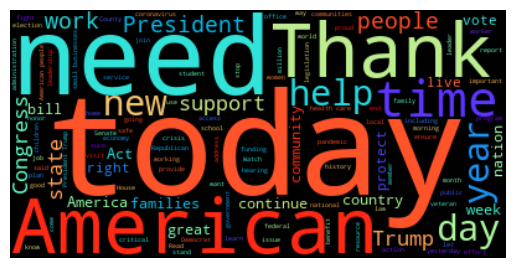

In [9]:
# apply function to text object
text = ' '.join(subset_df['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object by 
wordcloud = WordCloud(background_color = "black",  
                      colormap='rainbow',
                      random_state=3141).generate(text)              

# plot 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

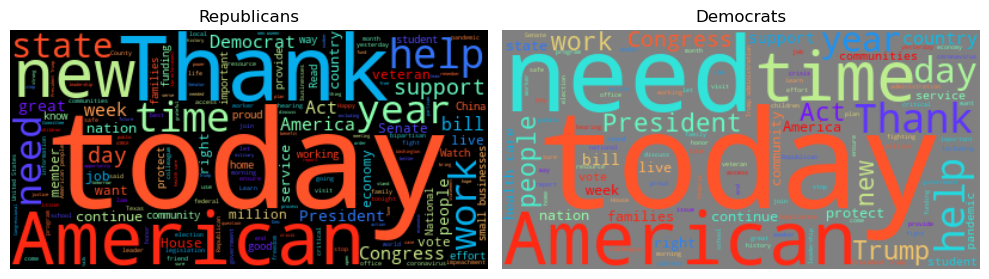

In [10]:
## I create two distinct wordclouds: one representing tweets coming from republicans and the other tweets coming from democrats

# Filter data for Republicans
republican_text = ' '.join(subset_df[subset_df['party'] == 'Republican']['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud for Republicans
republican_wordcloud = WordCloud(background_color="black", 
                                 colormap='rainbow', 
                                 random_state=3141).generate(republican_text)

# Plot Republican WordCloud
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(republican_wordcloud, interpolation='bilinear')
plt.title('Republicans')
plt.axis('off')

# Filter data for Democrats
democrat_text = ' '.join(subset_df[subset_df['party'] == 'Democrat']['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud for Democrats
democrat_wordcloud = WordCloud(background_color="grey", 
                               colormap='rainbow', 
                               random_state=3141).generate(democrat_text)

# Plot Democrat WordCloud
plt.subplot(1, 2, 2)
plt.imshow(democrat_wordcloud, interpolation='bilinear')
plt.title('Democrats')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

## Comments on wordclouds: 
## It's interesting that "thank" is way more used by republicans. And that democrat stands out in republicans' tweets whereas Trump stands out in democrat tweets. And the word "act" stands out more in democtats' tweets.

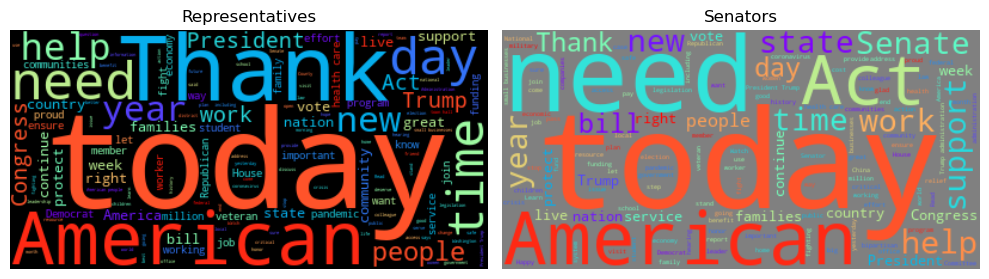

In [11]:
## I create two distinct wordclouds: one representing tweets coming from Senators and the other tweets coming from Representatives

# Filter data for Representatives
representative_text = ' '.join(subset_df[subset_df['position'] == 'Rep']['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud for Representatives
representative_wordcloud = WordCloud(background_color="black", 
                                 colormap='rainbow', 
                                 random_state=3141).generate(representative_text)

# Plot Representatives WordCloud
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(representative_wordcloud, interpolation='bilinear')
plt.title('Representatives')
plt.axis('off')

# Filter data for Senators
senator_text = ' '.join(subset_df[subset_df['position'] == 'Sen']['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud for Senators
senator_wordcloud = WordCloud(background_color="grey", 
                               colormap='rainbow', 
                               random_state=3141).generate(senator_text)

# Plot Senators WordCloud
plt.subplot(1, 2, 2)
plt.imshow(senator_wordcloud, interpolation='bilinear')
plt.title('Senators')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

## Comments on wordclouds: 
## Representatives' graph is closer to Republicans' graph, whereas Senatos' graph is closer to Democrats' graph. 

## EDA 2: Word/Character Count

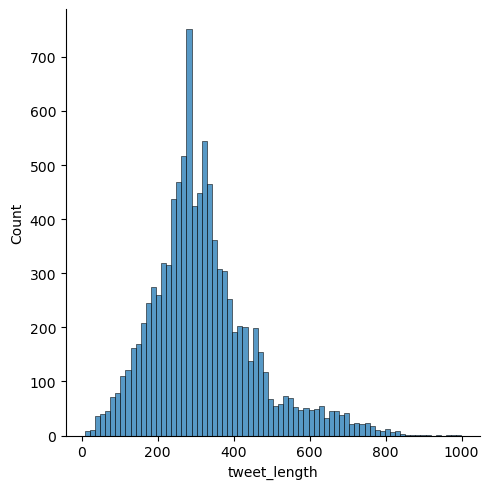

In [12]:
# count number of characters -- given that these are tweets and there are rules about lenght maybe this is not so important
subset_df['tweet_length'] = subset_df['text'].apply(len)

# create histogram of tweet length (number of characters)
sns.displot(subset_df, x="tweet_length")
plt.show()

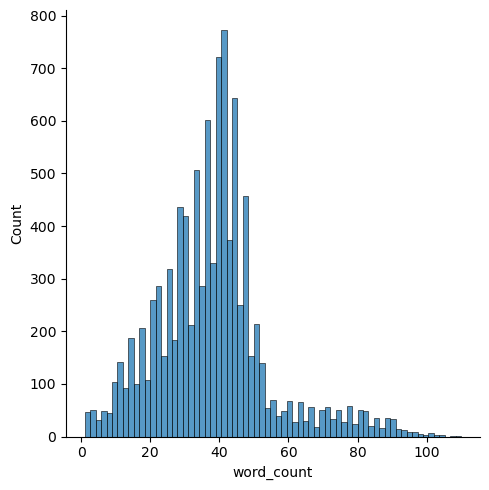

In [13]:
# count number of words
subset_df['word_count'] = subset_df['text'].apply(lambda x: len(str(x).split()))

# create histogram of tweet length (number of characters)
sns.displot(subset_df, x="word_count")
plt.show()

### EDA 3: Topic modeling

In [14]:
# create tf-idf matrix
# ----------

# set X dataset
X = subset_df['text']        

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                     token_pattern = None)      # set to "None" since we have specify our own pattern

# fit and transform data
tfidf_matrix = tf.fit_transform(X)

In [15]:
# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                         columns=tf.get_feature_names_out()) # specify column names as feature names from TF vectorizer

# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,9949,9950,9951,9952,9953,9954,9955,9956,9957,9958
lawmaker,0.384382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perjury,0.384382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
referring,0.374657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cohen,0.359993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
measure,0.329786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
testimony,0.279880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gop,0.253285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
investigation,0.251184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
force,0.239553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vote,0.189010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.146301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# K-means clustering
# ------------------------------

# implement kmeans clustering
# ----------
kmeans = KMeans(n_clusters=3,       # specify # of clusters
                max_iter=300        # specify # of iterations
                ).fit(tfidf_matrix) # specify data to fit

# append labels to dataframe
# ----------
subset_df['cluster']= kmeans.labels_    # add labels to original data frame
subset_df.head()

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_full_text,tweet_length,word_count,cluster
741664,1.123250e+18,RepMarkGreen,2019-04-30T11:26:09-04:00,RT @thehill JUST IN: GOP lawmaker to force Hou...,Mark E. Green,Rep,3-Jan-19,11/8/1964,M,TN,...,Republican,"1,522,925","870,695","960,709","1,462,330","[GOP, lawmaker, force, House, vote, measure, r...",GOP lawmaker force House vote measure referrin...,283,20,0
264129,1.303000e+18,RepHankJohnson,2020-09-07T11:52:02-04:00,.@uscensusbureau Census takers are visiting ho...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,...,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[Census, takers, visiting, households, respond...",Census takers visiting households responded re...,384,30,0
342410,1.266060e+18,Rep_Watkins,2020-05-28T13:13:40-04:00,An act of pure heroism. \n \nWe are all extrem...,Steve Watkins,Rep,3-Jan-19,9/18/1976,M,KS,...,Republican,"671,018","427,005","440,726","692,634","[act, pure, heroism, extremely, thankful, acti...",act pure heroism extremely thankful actions ta...,253,29,0
332433,1.221560e+18,RepCindyAxne,2020-01-26T17:16:22-05:00,Great to stop by Dallas County Hospital in Per...,Cindy Axne,Rep,3-Jan-19,4/20/1965,F,IA,...,Democrat,"800,983","653,669","822,544","730,617","[Great, stop, Dallas, County, Hospital, Perry,...",Great stop Dallas County Hospital Perry hear e...,337,42,1
807809,1.246560e+18,RepDanCrenshaw,2020-04-04T17:56:14-04:00,The smugness emanating from this tweet is prec...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[smugness, emanating, tweet, precisely, Americ...",smugness emanating tweet precisely Americans f...,504,76,2


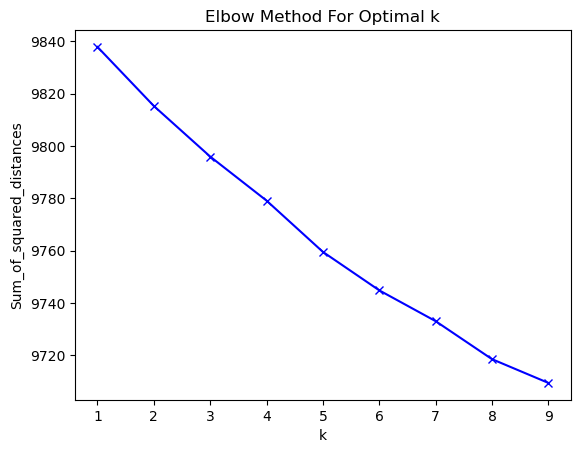

In [17]:
# determining optional k: elbow method
# ------------------------------

# settings
# ---------
# set an empty list 
Sum_of_squared_distances = []

# set range of k
K = range(1, 10) # second number is the ceiling of the range, but remember it is exclusive


# loop over k
# ---------
for k in K:
    km = KMeans(n_clusters=k,     # number of clusters
                init='k-means++', # method for initalization 
                n_init=10)        # number of times the k-means algorithm is run with different centroid seeds
    km = km.fit(tfidf_matrix)     # fit
    Sum_of_squared_distances.append(km.inertia_) # pipe inertia calculations into list


# plot results
# ---------
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(range(1, max(K) + 1, 1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## the less steep drop happens at 6

In [18]:
# determining optional k: silhouette scores
# ------------------------------

# iterate over a k-means fits to have different clusters
# ---------
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , random_state = 1)

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results


# calculate average silhouettes scores 
# ---------
# plot silhouettes scores
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

# plot silhouettes scores       
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg): 
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])   # play with this to set x-axis limits
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
# put it altogether
def silhouette(kmeans_dict, df, plot=True):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


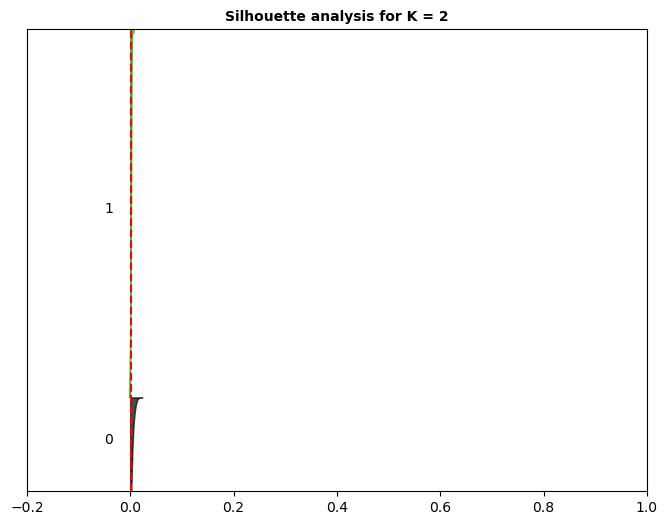

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


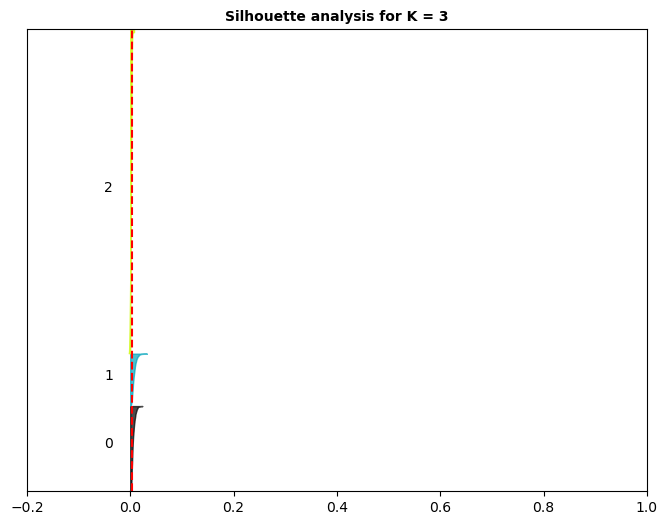

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


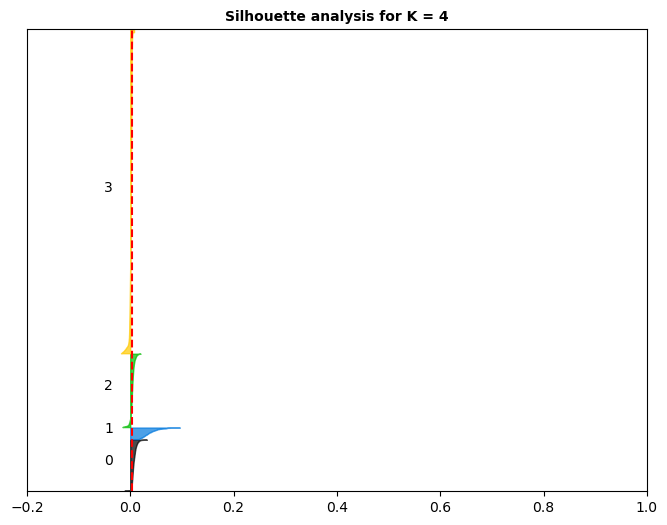

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


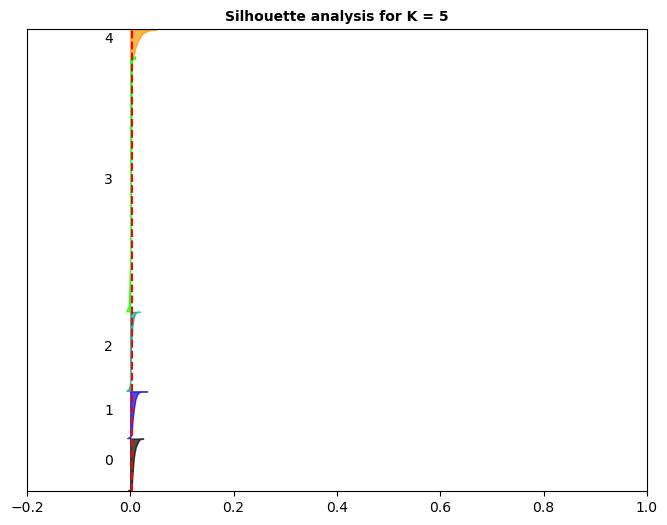

/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


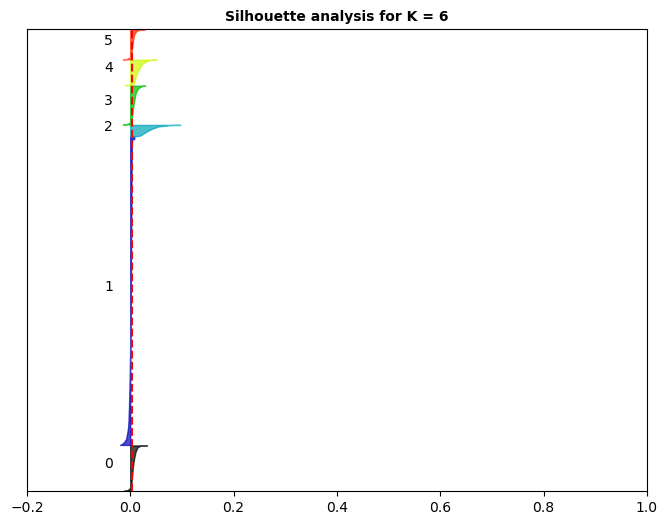

In [19]:
# calculate silhouette scores across potential k-means clusters 
# ---------

# set K
k = 6 # choose 7 based on the elbow method result from above

# run the k-means algorithm
kmeans_results = run_KMeans(k,                # set k
                            data = tfidf_df)  # identify data


# plot the silhouette analysis
silhouette(kmeans_results,     # take k-means results
           tfidf_df)           # use the dataframe version

In [20]:
# cluster analysis of top words in each cluster
# ------------------------------

# get the top features from each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

# plot them on a barplot
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

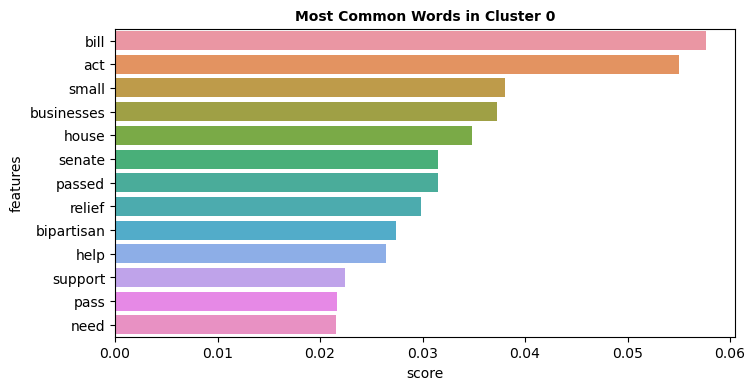

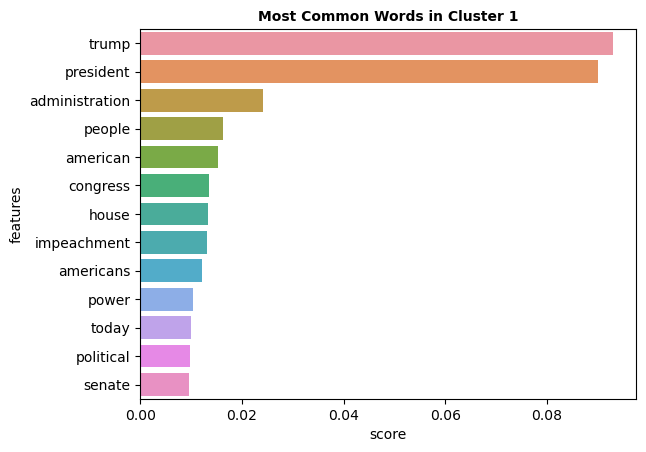

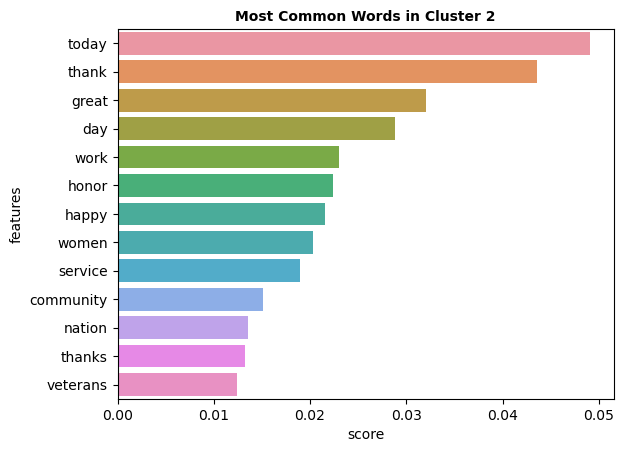

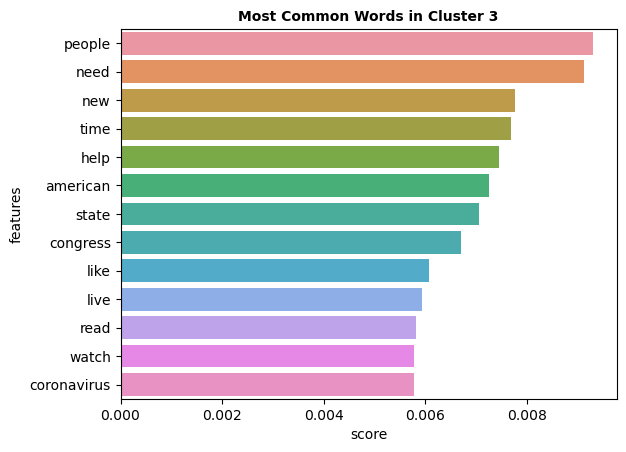

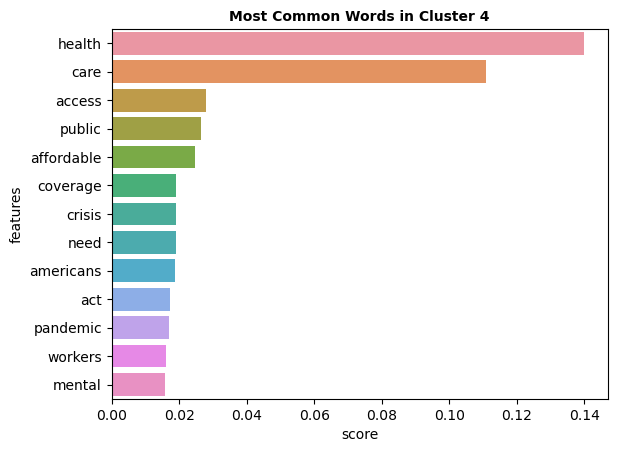

In [21]:
# run k-means and visualize word count
# ---------

# get results from 5 clusters 
best_result = 5
kmeans = kmeans_results.get(best_result)

# processing for plot
tfidf_array = tfidf_df.to_numpy()     # convert dataframe to array
prediction = kmeans.predict(tfidf_df) # predict cluster using tf-idf dataframe


# plot
n_feats = 20
dfs = get_top_features_cluster(tfidf_array, # specify dataset which is an array
                               prediction,  # make specify prediciton
                               n_feats )    # set number of features 
plotWords(dfs, # specify data for plotting  
          13)  # set number of features

In [22]:
# define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [23]:
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = subset_df['tokens_full_text']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

In [24]:
# apply tf-idf vectorizer to our data (X)
tfidf_matrix = tf.fit_transform(X)

In [25]:
# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

In [26]:
# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=0) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

In [27]:
# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


Topic #0:
today thank happy great join day town students hall community honor office service school questions thanks visit birthday week year

Topic #1:
de el la y en los para que paso christmas merry por newsletter las su release del un 28 arizonans

Topic #2:
file dcstatehood dorian trees tom blacklivesmatter dad curve icymi deposit blood winds hbcu tropical flatten fakeemergency stuck prayer noon gilbert

Topic #3:
trump today president act people need health house bill american congress time americans help work care senate new support families

Topic #4:
mask wear ed op barrett read statement amy wearing semitism juneteenth coney trumpbudget judge wildlife anti devos wash holocaust latinos



,0,1,2,3,4
0,0.047640,0.132522,0.047540,0.724763,0.047534
1,0.055457,0.054384,0.054348,0.780520,0.055292
2,0.043148,0.042601,0.042055,0.667792,0.204404
3,0.038724,0.037561,0.037561,0.848590,0.037564
4,0.031177,0.031010,0.030986,0.875839,0.030989
...,...,...,...,...,...
9954,0.751318,0.039520,0.041038,0.128593,0.039531
9955,0.033577,0.032958,0.032968,0.867479,0.033018
9956,0.840954,0.039182,0.039261,0.041356,0.039246
9957,0.040104,0.038614,0.038614,0.844054,0.038614


We have 5 topics. 

Topic 1 revolves around  support (words: thank, help, need, care). 
Topic 2 revolves around action (words: act, today, vote, protect, pass). 
Topic 3 revolves around safety (words: violence, assault, end gun violence, gun, violence, hope)
Topic 4 revolves around democracy (words: impeachment, trump, president, election, democrats, voting, democracy, ballot, vote). 
Topic 5 means we need to clean and preprocess the data better to make better use of these functions. 


## Sentiment Analysis

* Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

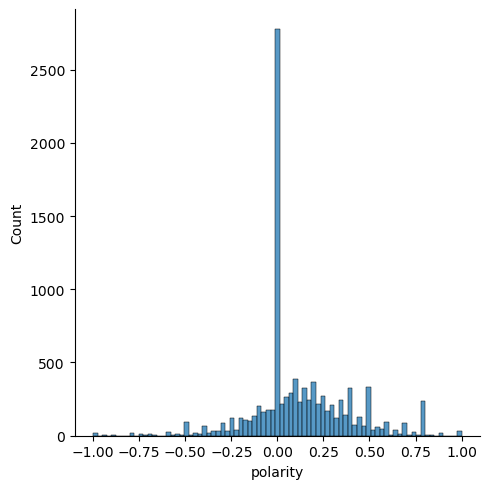

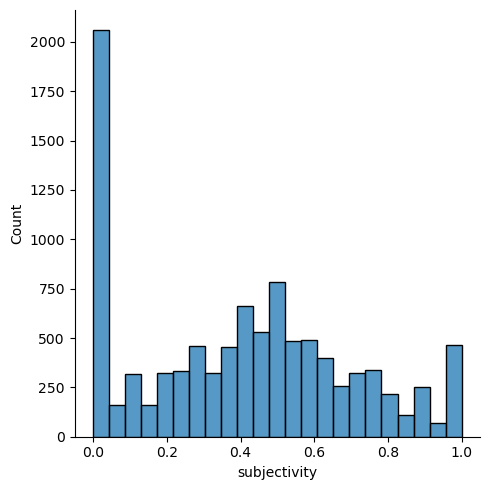

In [28]:
# create a feature colum of sentiment polarity and subjectivity
# ---------- 

# create new column feature of polarity
subset_df['polarity'] = subset_df['tokens_full_text'].map(lambda text: TextBlob(text).sentiment.polarity)

# create new column feature of subjectivity
subset_df['subjectivity'] = subset_df['tokens_full_text'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
subset_df[['tokens_full_text', 'polarity']].head()

# histogram of polarity
sns.displot(subset_df, x="polarity") 
plt.show()

# plot
sns.displot(subset_df, x="subjectivity") 
plt.show()

In [29]:
# loop to view the 5 most positive tweets
# ---------- 
for complaint in subset_df.nlargest(5, 'polarity')['text']:
    print(complaint + "\n")

Birth control gives people freedom &amp; agency over their bodies, lives, &amp; futures. Everyone deserves to use the contraception method that works best for them.

I’ll keep fighting to ensure access to birth control is the norm not the exception. #ThnxBirthControl

@HouseFloor @cspan @RepChipRoy @RepRWilliams @RepAndyHarrisMD @RepKenBuck @RepBenCline NEXT UP: @RepTedYoho has joined me on the floor to continue the conversation about our national debt being the greatest threat to our national security.

My website is an excellent resource for information on the services we provide and what I’m working on for Kansans. But my photos could use an update, and I need your help to show off the beauty of #KS03! Learn more about our photo contest here ➡️ https://davids.house.gov/services/district-photo-contest http://pbs.twimg.com/media/EBx5lbUWwAElDt7.jpg

This morning I spoke to the Laguna Niguel Chamber of Commerce about my work in D.C. and O.C. I also had had the honor of presenting 30 ye

In [30]:
# loop to view the 5 most positive tweets
# ---------- 
for complaint in subset_df.nsmallest(5, 'polarity')['text']:
    print(complaint + "\n")

Don’t answer your dad’s calls https://twitter.com/erictrump/status/1295543244139487233 QT @EricTrump This is absolutely terrible

For almost six years, 112 families have been hoping and praying—and fearing the worst. #BringBackOurGirls http://pbs.twimg.com/media/EGmg8bMXkAEp4_x.jpg

No collusion, no coordination, no reason for Congressional Democrats to keep up this divisive and outrageous attempts to mislead Americans and discredit the President of the United States.

Efforts to delay the Fifth National Climate Assessment are outrageous and unacceptable. Once again, the Trump Admin is trying to sideline climate science and elevate the voices of climate deniers. We must #DefendScience
 
https://www.eenews.net/stories/1063715433

RT @RepEscobar As El Pasoans, from the moment we learned of the horrific events, we have opened up our hearts and wrapped our arms around those in pain and suffering. http://pbs.twimg.com/media/EBLwlsgUwAEYFFD.jpg http://pbs.twimg.com/media/EBLwlsgUcAAfCqI.jpg 

In [31]:
# loop to view the 5 most subjective tweets
# ---------- 
for complaint in subset_df.nlargest(5, 'subjectivity')['text']:
    print(complaint + "\n")

We have an opportunity in 8 days to send a message to those out of touch Republican senators who think progress is what you see in the rear view, not what’s out the windshield.

VOTE! https://twitter.com/reploritrahan/status/1320880259110240257 QT @RepLoriTrahan 38 days since RBG passed &amp; 8 days before the most consequential election of our lives, President Trump &amp; Mitch McConnell have completed their power grab.

Barrett’s positions on health care, women’s rights, climate change, LGBTQ equality, voting rights &amp; more are frightening.

RT @SenJohnHoeven Last stretch of transferring the title of the Oakes Test Area to the Dickey-Sargent Irrigation District will be final after the 90-day Congressional review period. Outlined this to #NDag w/ @interior, @usbr officials + @SenKevinCramer &amp; @RepArmstrongND. https://www.hoeven.senate.gov/news/news-releases/hoeven-cramer-and-armstrong-oakes-test-area-title-transfer-to-be-final-after-90-day-congressional-review

Honored to stand

In [32]:
# loop to view the 5 least subjective tweets
# ---------- 
for complaint in subset_df.nsmallest(5, 'subjectivity')['text']:
    print(complaint + "\n")

RT @thehill JUST IN: GOP lawmaker to force House vote on measure referring Cohen's testimony for perjury investigation https://thehill.com/homenews/house/441319-gop-rep-to-force-house-vote-on-measure-referring-cohen-testimony-to-doj-for http://pbs.twimg.com/media/D5aHbJFX4AACAs5.jpg

.@uscensusbureau Census takers are visiting households that have not yet responded. So if you’ve already responded to the 2020 Census, why might a census taker visit? 
Read More: https://www.census.gov/newsroom/blogs/director/2020/08/visit-after-responding.html?utm_campaign=20200904msprts1ccpuprs&utm_medium=email&utm_source=govdelivery http://pbs.twimg.com/media/EhUt1flXkAE8alf.jpg

I join our community members in grieving &amp; praying for the victims of the mass shooting at the Gilroy Garlic Festival. I am grateful for law enforcement's &amp; first responder’s swift response, (1/2)

RT @DBrandewie 13 GOP senators back bipartisan bill to make Juneteenth a federal holiday https://www.axios.com/senate-repub

Both of these measures look weird. Polarity is centered around 0 and subjectivity is centered around 0.5. However, we do find some difference when we do subgroup analysis. 

In [33]:
## analyzing Steve Chabot (conservative) and Barbara Lee (democrat)

# Average polarity 
avg_polarity = subset_df['polarity'].mean()
print("Average Polarity for Full Sample:", avg_polarity)

# Average polarity by democrats and republicans
avg_polarity_by_party = subset_df.groupby('party')['polarity'].mean()
avg_polarity_republicans = avg_polarity_by_party.get('Republican', 0)  # 0 is the default if 'Republican' is not found
avg_polarity_democrats = avg_polarity_by_party.get('Democrat', 0)  # 0 is the default if 'Democratic' is not found
print("Average Polarity for Republicans:", avg_polarity_republicans)
print("Average Polarity for Democrats:", avg_polarity_democrats)

# Average polarity by representatives and senators
avg_polarity_by_position = subset_df.groupby('position')['polarity'].mean()
avg_polarity_representatives = avg_polarity_by_position.get('Rep', 0)  
avg_polarity_senators = avg_polarity_by_position.get('Sen', 0)  
print("Average Polarity for Representatives:", avg_polarity_representatives)
print("Average Polarity for Senators:", avg_polarity_senators)

# Group by 'name_wikipedia' and calculate the mean polarity
steve_chabot_avg_polarity = subset_df[subset_df['name_wikipedia'] == "Steve Chabot"]['polarity'].mean()
print("Average Polarity for Steve Chabot:", steve_chabot_avg_polarity)

# Group by 'name_wikipedia' and calculate the mean polarity
barbara_lee_avg_polarity = subset_df[subset_df['name_wikipedia'] == "Barbara Lee"]['polarity'].mean()
print("Average Polarity for Barbara Lee:", barbara_lee_avg_polarity)

###### 

# Average subjectivity  
avg_subjectivity = subset_df['subjectivity'].mean()
print("Average Subjectivity for Full Sample:", avg_subjectivity)

# Average polarity by democrats and republicans
avg_subjectivity_by_party = subset_df.groupby('party')['subjectivity'].mean()
avg_subjectivity_republicans = avg_polarity_by_party.get('Republican', 0)  # 0 is the default if 'Republican' is not found
avg_subjectivity_democrats = avg_polarity_by_party.get('Democrat', 0)  # 0 is the default if 'Democratic' is not found
print("Average Subjectivity for Republicans:", avg_subjectivity_republicans)
print("Average Subjectivity for Democrats:", avg_subjectivity_democrats)

# Average subjetivity by representatives and senators
avg_subjectivity_by_position = subset_df.groupby('position')['subjectivity'].mean()
avg_subjectivity_representatives = avg_polarity_by_position.get('Rep', 0)  
avg_subjectivity_senators = avg_polarity_by_position.get('Sen', 0)  
print("Average Subjectivity for Representatives:", avg_subjectivity_representatives)
print("Average Subjectivity for Senators:", avg_subjectivity_senators)

# Group by 'name_wikipedia' and calculate the mean subjectivity 
steve_chabot_avg_subjectivity = subset_df[subset_df['name_wikipedia'] == "Steve Chabot"]['subjectivity'].mean()
print("Average Subjectivity for Steve Chabot Waltz:", steve_chabot_avg_subjectivity)

# Group by 'name_wikipedia' and calculate the mean polarity
barbara_lee_avg_subjectivity = subset_df[subset_df['name_wikipedia'] == "Barbara Lee"]['subjectivity'].mean()
print("Average Subjectivity for Barbara Lee:", barbara_lee_avg_subjectivity)

Average Polarity for Full Sample: 0.12017457347936683
Average Polarity for Republicans: 0.13533344452075402
Average Polarity for Democrats: 0.11149526408475606
Average Polarity for Representatives: 0.12232298497868437
Average Polarity for Senators: 0.11331413019059874
Average Polarity for Steve Chabot: 0.11053561935140883
Average Polarity for Barbara Lee: 0.11606843511098831
Average Subjectivity for Full Sample: 0.40187533926724184
Average Subjectivity for Republicans: 0.13533344452075402
Average Subjectivity for Democrats: 0.11149526408475606
Average Subjectivity for Representatives: 0.12232298497868437
Average Subjectivity for Senators: 0.11331413019059874
Average Subjectivity for Steve Chabot Waltz: 0.31295986177565127
Average Subjectivity for Barbara Lee: 0.4298960731939455


We see a higher polarity score for Barbara Lee (liberal) relative to Steve Chabot (conservative), although it is pretty low for both of them so I don't know if I chose the best examples. Also, both of them are below the mean for the subjectivity index, and here again Barbara Lee (liberal) scores higher in subjectivity relative to Steve Chabot (conservative). I think I would have expected it to be the other way round. I also don't know how to interpret that 40% of the sample are being subjective, it seems a lot, but this is also tweets, right? It's the place for opinion, so perhaps it makes sense.  

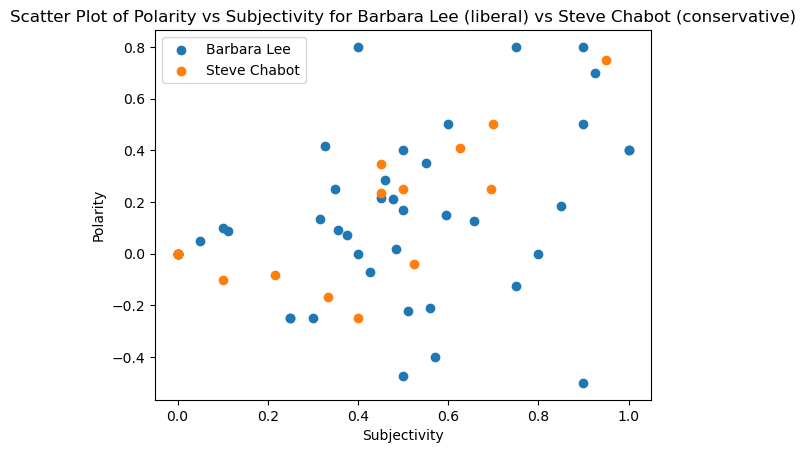

In [34]:
## scatter plot of polarity versus subjectivity for both legislators 

barbara_lee_data = subset_df[subset_df['name_wikipedia'] == 'Barbara Lee']
steve_chabot_data = subset_df[subset_df['name_wikipedia'] == 'Steve Chabot']

# Create scatter plot
plt.scatter(barbara_lee_data['subjectivity'], barbara_lee_data['polarity'], label='Barbara Lee')
plt.scatter(steve_chabot_data['subjectivity'], steve_chabot_data['polarity'], label='Steve Chabot')

# Add labels and title
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Scatter Plot of Polarity vs Subjectivity for Barbara Lee (liberal) vs Steve Chabot (conservative)')
plt.legend()

# Show plot
plt.show()

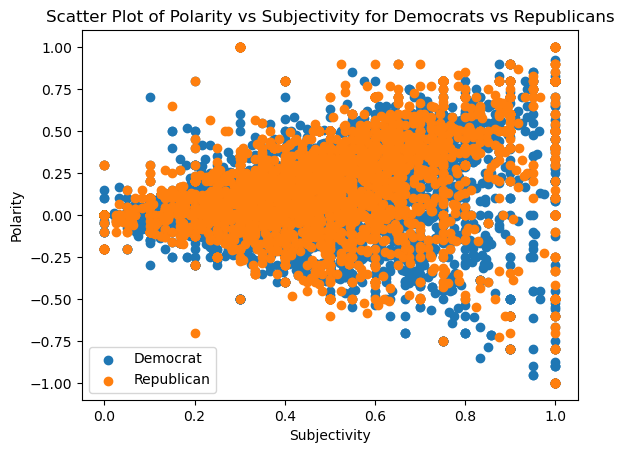

In [35]:
## scatter plot of sentiment versus polarity for democrats vs republicans 

democrat = subset_df[subset_df['party'] == 'Democrat']
republican = subset_df[subset_df['party'] == 'Republican']

# Create scatter plot
plt.scatter(democrat['subjectivity'], democrat['polarity'], label='Democrat')
plt.scatter(republican['subjectivity'], republican['polarity'], label='Republican')

# Add labels and title
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Scatter Plot of Polarity vs Subjectivity for Democrats vs Republicans')
plt.legend()

# Show plot
plt.show()

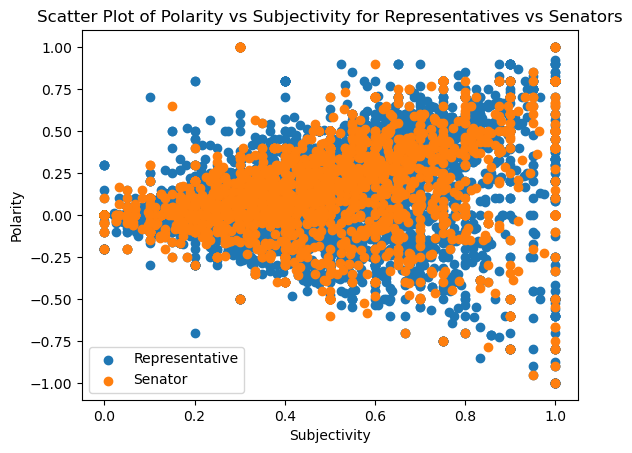

In [36]:
## scatter plot of sentiment versus polarity for representatives vs senators 

representative = subset_df[subset_df['position'] == 'Rep']
senator = subset_df[subset_df['position'] == 'Sen']

# Create scatter plot
plt.scatter(representative['subjectivity'], representative['polarity'], label='Representative')
plt.scatter(senator['subjectivity'], senator['polarity'], label='Senator')

# Add labels and title
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Scatter Plot of Polarity vs Subjectivity for Representatives vs Senators')
plt.legend()

# Show plot
plt.show()

The first graph is not very conclusive to me, but maybe it's because by plotting only two legislators we don't have enough observations to see a pattern? 
However, if we plot polarity against subjectivity for all democrats and all republicans, we see that there's pretty much perfect overlap, so that relationship is going in the same direction for both groups. 

* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

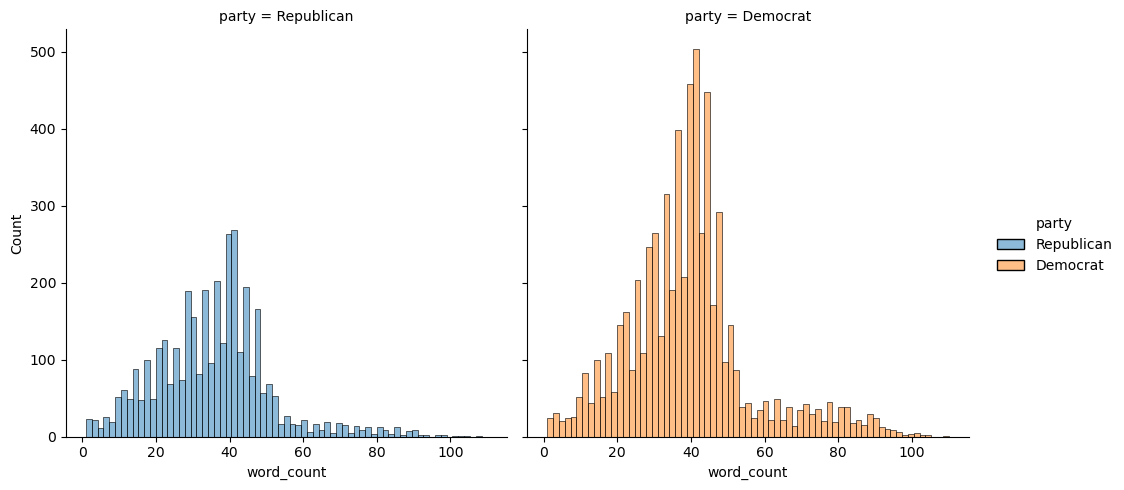

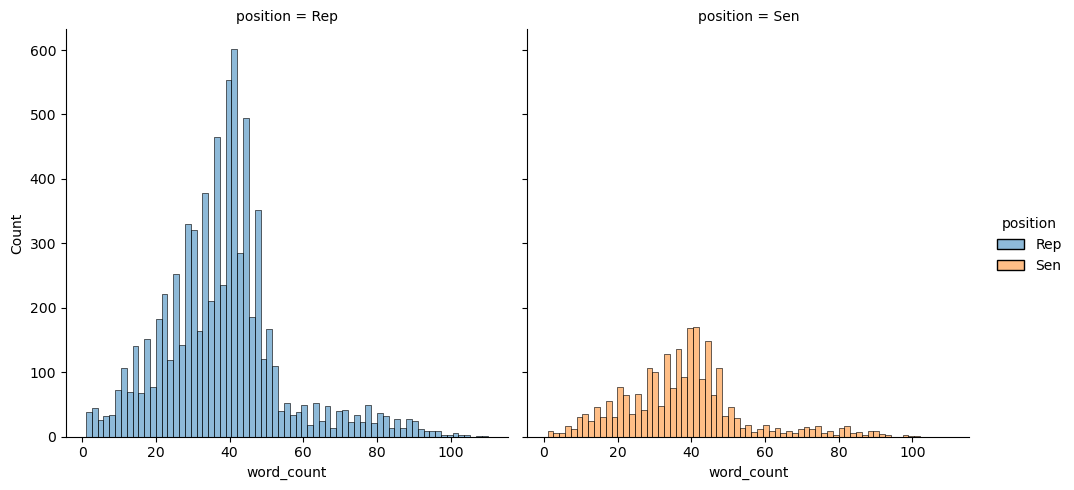

In [37]:
## Histograms that compare tweet length for republicans vs democrats and for senators vs representatives 

sns.displot(subset_df, 
            x="word_count", 
            hue="party", 
            col = "party") ## how do I tell it not to show independent without filtering the data before? 
plt.show()

sns.displot(subset_df, 
            x="word_count", 
            hue="position", 
           col = "position")
plt.show()

There are more tweets coming from Democrats relative to Republicans, but the distribution and average length are similar. 
There are more tweets coming from Representatives relative to Senators, but the distributions are also not that different. 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [38]:
# Engineered Text Features: select engineered text features
engineered_features = subset_df[['tweet_length', 
                                 'word_count', 
                                 'polarity', 
                                 'subjectivity']].reset_index(drop = True)

engineered_features.head(10)

,tweet_length,word_count,polarity,subjectivity
0,283,20,0.000000,0.000000
1,384,30,0.000000,0.000000
2,253,29,0.029762,0.666667
3,337,42,0.525000,0.825000
4,504,76,-0.150000,0.622222
5,475,49,-0.033333,0.133333
6,188,31,-0.250000,0.250000
7,241,28,0.000000,0.500000
8,596,80,0.281818,0.642614
9,317,35,0.183333,0.516667


In [39]:
# Topic Model + Engineered Features: combine results from our topic model + engineered features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

engineered_features_with_topics.head(10)

,0,1,2,3,4,tweet_length,word_count,polarity,subjectivity
0,0.047640,0.132522,0.047540,0.724763,0.047534,283,20,0.000000,0.000000
1,0.055457,0.054384,0.054348,0.780520,0.055292,384,30,0.000000,0.000000
2,0.043148,0.042601,0.042055,0.667792,0.204404,253,29,0.029762,0.666667
3,0.038724,0.037561,0.037561,0.848590,0.037564,337,42,0.525000,0.825000
4,0.031177,0.031010,0.030986,0.875839,0.030989,504,76,-0.150000,0.622222
5,0.040358,0.039007,0.301353,0.580627,0.038655,475,49,-0.033333,0.133333
6,0.042186,0.041752,0.353481,0.521420,0.041161,188,31,-0.250000,0.250000
7,0.338275,0.040961,0.040962,0.538843,0.040959,241,28,0.000000,0.500000
8,0.408165,0.031018,0.030993,0.498818,0.031005,596,80,0.281818,0.642614
9,0.038925,0.037808,0.038274,0.483572,0.401420,317,35,0.183333,0.516667


### Bag-of-words or Tf-idf

In [40]:
# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # set feature names

tfidf_df.head(10)

,0,0001,01453,0148,018,0211,03,0385,0416,0555,...,𝗿𝗲𝘀𝗵𝗮𝗽𝗶𝗻𝗴,𝘁𝗵𝗶𝘀,𝘙𝘰𝘦,𝘞𝘢𝘥𝘦,𝟏,𝟏𝟐𝟑,𝟏𝟑𝟖,𝟭𝟲,𝟮𝟰,𝟯𝟭
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [41]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

In [42]:
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model
model_path = 'data/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [43]:
vector = word2vec_model['word']

model = gensim.models.Word2Vec(subset_df['tokens'],    # specify data - sentences
                               vector_size=100,        # set embedding size at 100
                               window=5,               # max distance between current and predicted word
                               min_count=5,            # ignores words with freq fewer than this threshold
                               sg=0,                   # specify Continuous Bag of Words Algorithim
                               alpha=0.025,            # learning rate
                               epochs = 5,             # iterations
                               seed = 12,              # set random seed (same as random_state in sklearn )
                               batch_words=10000,      # sample size 
                               workers = 1)  

In [44]:
# create function to iterate over every token and document in our corpus
# ---------
def document_vector(word2vec_model, doc):
    # Filter out words that are not present in the vocabulary
    doc = [word for word in doc if word in word2vec_model.key_to_index]
    if doc:  # Check if doc is not empty
        return np.mean(word2vec_model.__getitem__(doc), axis=0)
    else:
        # Return None or any default value if doc is empty
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if doc is empty

In [45]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for doc in subset_df['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, doc))

# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# make df of averages
word2vec_df = pd.DataFrame(doc_average_embeddings)

In [46]:
# return a list of word for which we have calculations
# ----------
words = list(model.wv.index_to_key)
print(words[0:100])  # print the first 100 words

['Trump', 'people', 'today', 'need', 'Act', 'President', 'help', 'American', 'House', 'work', 'time', 'Congress', 'health', 'Americans', 'bill', 'Today', 'support', 'care', 'country', 'Senate', 'families', 'Thank', 'years', 'America', 'year', 'new', 'continue', 'working', 'public', 'workers', 'day', 'community', 'week', 'like', 'communities', 'federal', 'vote', 'nation', 'protect', 'state', 'pandemic', 'businesses', 'crisis', 'proud', 'women', 'great', 'fight', 'important', 'coronavirus', 'right', 'legislation', 'bipartisan', 'Democrats', 'funding', 'passed', 'know', 'ensure', 'family', 'law', 'lives', 'economy', 'access', 'students', 'relief', 'service', 'government', 'honor', 'small', 'join', 'million', 'way', 'forward', 'provide', 'safe', 'home', 'local', 'office', '1', 'children', 'pass', 'jobs', 'sure', 'colleagues', 'hearing', 'security', 'Republicans', 'resources', 'want', 'rights', 'critical', 'stop', 'national', 'members', 'life', 'border', 'discuss', 'National', 'end', 'Thank

In [47]:
## just for fun 

# similarity between Democrat and Republican
# ----------
similarity_democrat_republican = model.wv.similarity('Democrat', 'Republican')
print("Similarity between democrat and republican:", similarity_democrat_republican)

# similarty between act and speak
# ----------
similarity_act_speak = model.wv.similarity('act', 'speak')
print("Similarity between act and speak:", similarity_act_speak)

# which doesn't belong? 1
# ----------
which_does_not_belong = model.wv.doesnt_match(['Democrat', 'Republican', 'Americans']) ## so interesting that it's picking Democrat here as the word that does NOT belong 
print("Which does not belong between Democrat, Republcian and Americans?:", which_does_not_belong)

# vector math
# ----------
most_similar = model.wv.most_similar(positive=['Democrat', 'act', 'today'], 
                      negative=['impeachment', 'law'])
print("Which is most similar?:", most_similar)

Similarity between democrat and republican: 0.9991301
Similarity between act and speak: 0.99843717
Which does not belong between Democrat, Republcian and Americans?: Americans
Which is most similar?: [('great', 0.9961037635803223), ('County', 0.9958102107048035), ('Happy', 0.9957079887390137), ('Thanks', 0.9956645965576172), ('district', 0.9956133365631104), ('Thank', 0.995559573173523), ('members', 0.995558500289917), ('discuss', 0.99537593126297), ('Day', 0.995328962802887), ('High', 0.9953078627586365)]


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [48]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

In [49]:
# model = LogisticRegression(max_iter=500)
# df = dataframes[0]
# model.fit(df.to_numpy(), labels[0][0].argmax(axis=1))

In [50]:
# Initialize a list of dataframes from the objects created above
dataframes = [engineered_features, tfidf_df]
dataframe_names = ['engineered_features', 'tfidf_df']

# Create label binarizer for party (Democrat/Republican)
party_lb = LabelBinarizer()
party_labels = party_lb.fit_transform(subset_df["party"])  # Binarize party labels

# Create label binarizer for party (Democrat/Republican)
position_lb = LabelBinarizer()
position_labels = position_lb.fit_transform(subset_df["position"])  # Binarize position labels

labels = [(party_labels, 'Party Affiliation'), (position_labels, 'Position')]

In [51]:
## I cannot get the function to work so I'm doing one by one. Sorry about that!     

# engineered_features - party 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(engineered_features, 
                                                    party_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.6340361445783133
Confusion Matrix:
[[1248   23]
 [ 706   15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.77      1271
           1       0.39      0.02      0.04       721

    accuracy                           0.63      1992
   macro avg       0.52      0.50      0.41      1992
weighted avg       0.55      0.63      0.51      1992




In [52]:
# engineered_features - position 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(engineered_features, 
                                                
                                                    position_labels, 
                                                
                                                    test_size=0.2, 
                                                
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.7720883534136547
Confusion Matrix:
[[1538    0]
 [ 454    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1538
           1       0.00      0.00      0.00       454

    accuracy                           0.77      1992
   macro avg       0.39      0.50      0.44      1992
weighted avg       0.60      0.77      0.67      1992




/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brenda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
## tfidf_df - party
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, 
                                                    party_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.7203815261044176
Confusion Matrix:
[[1165  106]
 [ 451  270]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1271
           1       0.72      0.37      0.49       721

    accuracy                           0.72      1992
   macro avg       0.72      0.65      0.65      1992
weighted avg       0.72      0.72      0.69      1992




In [54]:
## tfidf_df - position

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, 
                                                    position_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.7786144578313253
Confusion Matrix:
[[1525   13]
 [ 428   26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1538
           1       0.67      0.06      0.11       454

    accuracy                           0.78      1992
   macro avg       0.72      0.52      0.49      1992
weighted avg       0.75      0.78      0.70      1992




In [55]:
## word_embeddings - party

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_average_embeddings, 
                                                    party_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.6837349397590361
Confusion Matrix:
[[1089  182]
 [ 448  273]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1271
           1       0.60      0.38      0.46       721

    accuracy                           0.68      1992
   macro avg       0.65      0.62      0.62      1992
weighted avg       0.67      0.68      0.66      1992




In [56]:
## word_embeddings - position

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_average_embeddings, 
                                                    position_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.7796184738955824
Confusion Matrix:
[[1521   17]
 [ 422   32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1538
           1       0.65      0.07      0.13       454

    accuracy                           0.78      1992
   macro avg       0.72      0.53      0.50      1992
weighted avg       0.75      0.78      0.70      1992




### Two Combined Models

In [57]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

## tf-idf worked better then engineered features, so I'm comibing this df with text features and non text features. 

# Non-text features
# --------
# select non-text features
non_text_features = subset_df[['state', 
                               'position', 
                               'gender',
                               'birthday', 
                               'joined_congress_date', 
                               'clinton_2016_state_share',
                               'obama_2012_state_share', 
                               'romney_2012_state_share']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

In [58]:
## non-text features - party

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(non_text_features_dummies, 
                                                    party_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.9984939759036144
Confusion Matrix:
[[1270    1]
 [   2  719]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       721

    accuracy                           1.00      1992
   macro avg       1.00      1.00      1.00      1992
weighted avg       1.00      1.00      1.00      1992




In [59]:
## tfidf_df non-text features - party

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(non_text_plus_tfidf, 
                                                    party_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 0.9964859437751004
Confusion Matrix:
[[1268    3]
 [   4  717]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      0.99      1.00       721

    accuracy                           1.00      1992
   macro avg       1.00      1.00      1.00      1992
weighted avg       1.00      1.00      1.00      1992




In [60]:
## non-text features - position

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(non_text_features_dummies, 
                                                    position_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 1.0
Confusion Matrix:
[[1538    0]
 [   0  454]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1538
           1       1.00      1.00      1.00       454

    accuracy                           1.00      1992
   macro avg       1.00      1.00      1.00      1992
weighted avg       1.00      1.00      1.00      1992




In [61]:
## tfidf_df non-text features - position

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(non_text_plus_tfidf, 
                                                    position_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Initialize the model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train,    
            y_train.ravel())

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion_mat}')
print(f'Classification Report:\n{class_report}\n')

Accuracy: 1.0
Confusion Matrix:
[[1538    0]
 [   0  454]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1538
           1       1.00      1.00      1.00       454

    accuracy                           1.00      1992
   macro avg       1.00      1.00      1.00      1992
weighted avg       1.00      1.00      1.00      1992




## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing techniques provide a good starting point for text analysis. However, it's necessary to adapt these techniques to the specific needs and context of your dataset to be able to perform a more accurate analysis. Some examples might be the following: 

** Domain-specific terminology or jargon, such as abbreviations or acronyms.

** Irregularities, such as misspellings, grammatical errors, or slang, or the use of informal language. 

** Sentiment analysis may require handling negation, sarcasm, formality or emoticons, among others.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

Yes, we can see that republicans have, on average, a higher polarity score (0.14 republicans vs 0.10 democrats) and higher subjectivity score (again, 0.14 republicans vs. 0.10 democrats). In the particular example given the legislators that I randomly picked, I found it was the other way round, meaning that the democratic legislator had both a higher polarity and subjectivity score, but perhaps I did not pick good examples that extrapolate over the overall sample. We do not see, however, the same trend for representatives and senators. Both representatives and senators show a polarity and subjectivity score of 0.11. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory and unsupervised learning approaches with a supervised learning algorithm can be valuable for the following reasons: 

** Because supervised learning algorithms are trained on labeled data, they allow for a more objective assessment of the effectiveness and accuracy of the unsupervised methods.

** Exploratory and unsupervised learning methods help reveal hidden patterns in data. When we confirm these findings using supervised learning algorithms, we might get better insights or it might give us a better understanding of the data's underlying structure.

** Validating unsupervised techniques with supervised models helps achieve generalizability of the insights and patterns to be applied to unseen data. 

** Validating unsupervised techniques with supervised models can help in explaining relationships between features and target variables.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

Using text only has a lower accuracy score (73% for party and 77% for position), but either using non-text features or using text and non-text features combined has an accuracy score of 98% or higher. Intuition: Combining text and non-text features in a supervised learning algorithm allows us to take advantage of the strengths of both types of features. Text features capture the linguistic content and semantics of the data, while non-text features provide additional context or domain knowledge that we cannot get from text alone. By combining both, we can improve predictive performance. What is not so clear to me here (maybe I made a coding mistake) is why non-text features alone was better than text alone. 